In [217]:
#import libraries

import os
import glob
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from radiant_mlhub import Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

In [218]:
field_crop_pair = pd.read_csv('field_crop_pair.csv')

In [219]:
train_data = pd.read_csv('train_data.csv')

In [220]:
test_data = pd.read_csv('test_data.csv')

In [221]:
# Each field has several pixels in| the data. Here our goal is to build a Random Forest (RF) model using the average values
# of the pixels within each field. So, we use `groupby` to take the mean for each field_id

train_data_grouped = train_data.groupby(['field_id']).head(10)
train_data_grouped.field_id = [str(int(i)) for i in train_data_grouped.field_id.values]
train_data_grouped.head()

D:\anacon\envs\py310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
0,11031,43,39,38,38,41,54,63,61,64,12,57,37,757
1,11287,43,39,38,38,42,57,67,63,72,12,63,42,757
2,11288,43,39,38,37,41,59,69,65,78,12,68,43,757
3,11289,43,38,37,36,41,59,69,64,78,12,68,43,757
4,11543,43,39,38,38,42,57,67,64,72,12,63,42,757


In [222]:
# merge pixel dataframe to field_crop_pair dataframe
field_crop_pair.field_id = [str(int(i)) for i in field_crop_pair.field_id.values]
train_df = pd.merge(train_data_grouped, field_crop_pair , on='field_id' )
train_df.head(10)

,Unnamed: 0_x,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,Unnamed: 0_y,crop_id
0,11031,43,39,38,38,41,54,63,61,64,12,57,37,757,1,6
1,11287,43,39,38,38,42,57,67,63,72,12,63,42,757,1,6
2,11288,43,39,38,37,41,59,69,65,78,12,68,43,757,1,6
3,11289,43,38,37,36,41,59,69,64,78,12,68,43,757,1,6
4,11543,43,39,38,38,42,57,67,64,72,12,63,42,757,1,6
5,11544,43,39,39,37,41,59,69,66,78,12,68,43,757,1,6
6,11545,43,39,39,37,41,59,69,68,78,12,68,43,757,1,6
7,11546,44,39,39,36,41,59,69,67,78,12,67,43,757,1,6
8,11547,44,38,38,35,41,59,69,65,78,12,67,43,757,1,6
9,11800,43,38,37,34,39,59,70,62,76,12,63,39,757,1,6


In [223]:
train_df.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace = True)

In [224]:
test_data = test_data.drop('Unnamed: 0', axis = 1)

In [225]:
# Each field has several pixels in| the data. Here our goal is to build a Random Forest (RF) model using the average values
# of the pixels within each field. So, we use `groupby` to take the mean for each field_id

test_data_grouped = test_data.groupby(['field_id']).tail(1)
test_data_grouped.field_id = [str(int(i)) for i in test_data_grouped.field_id.values]
test_data_grouped

D:\anacon\envs\py310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
130,40,38,37,39,42,53,60,60,68,13,57,39,5407
167,46,39,34,30,33,50,60,54,66,11,48,28,6309
169,46,39,34,30,32,48,58,55,63,11,44,25,6311
186,46,39,34,29,32,47,56,53,62,10,43,25,6314
201,46,39,34,31,34,46,56,52,61,10,49,33,6310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49184,44,39,37,39,45,55,61,57,67,15,76,59,3286
49217,43,37,35,33,38,54,62,58,67,15,63,41,3595
49277,43,37,37,37,43,58,67,62,75,12,73,49,971
49293,43,36,36,34,38,60,71,64,77,13,63,39,626


In [229]:
train_df['crop_id'].value_counts()

1     20008
4     14691
2      9726
9      2887
6      1619
36     1163
3      1001
13      577
8       462
15      387
5       204
16      143
14      131
Name: crop_id, dtype: int64

In [230]:
train_df.isna().sum()

B01         0
B02         0
B03         0
B04         0
B05         0
B06         0
B07         0
B08         0
B8A         0
B09         0
B11         0
B12         0
field_id    0
crop_id     0
dtype: int64

In [231]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [232]:
sm = SMOTE(random_state = 1)

In [233]:
# split data for model training and evaluation 

X_train, X_test, y_train, y_test =  train_test_split(train_df.drop(['field_id', 'crop_id'], axis=1), train_df['crop_id'] , test_size=0.1, random_state=42 , stratify = train_df['crop_id'])

In [234]:
from sklearn.feature_selection import SelectKBest,chi2

In [235]:
# selector = SelectKBest(k = 20)
# selector.fit(X_trainsm,y_trainsm)

In [236]:
# vector_names = list(X_trainsm.columns[selector.get_support(indices = True)])
# print(vector_names)

In [237]:
# X_trainb = X_trainsm[vector_names]
# X_testb = X_test[vector_names]

In [238]:
# pip install mlxtend

In [239]:
# from mlxtend.feature_selection import SequentialFeatureSelector

In [240]:
# feat_sel = SequentialFeatureSelector(rf, k_features = 20,forward = True, verbose =2, scoring = 'accuracy', cv = 3)

In [241]:
# feat_sel.fit(X_trainsm, y_trainsm )

In [242]:
# features = list(feat_sel.k_feature_names_)
# features = list(map(int, features))

In [243]:
# rf.fit(X_trainsm[features], y_trainsm)

In [244]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47699, 12), (5300, 12), (47699,), (5300,))

In [245]:
X_trainsm, y_trainsm = sm.fit_resample(X_train,y_train)

In [246]:
band_data = X_trainsm.columns.tolist()

In [247]:
#Broadband B03ness

# def creating_features():
    
# X_trainsm['DVI'] = X_trainsm['B08'] - X_trainsm['B04']
#X_trainsm['EVI'] = 2.5*((X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + 6 * X_trainsm['B04'] - 7.5 * X_trainsm['B02'] + 1))
X_trainsm['GLI'] = ((X_trainsm['B03'] - X_trainsm['B04']) + (X_trainsm['B03'] - X_trainsm['B02'])) / ((2 * X_trainsm['B03']) + X_trainsm['B04'] + X_trainsm['B02'])
X_trainsm['GDVI'] = X_trainsm['B08'] - X_trainsm['B03']
X_trainsm['GNDVI'] = (X_trainsm['B08'] - X_trainsm['B03'])/(X_trainsm['B08'] + X_trainsm['B03'])
# X_trainsm['GOSAVI'] = (X_trainsm['B08'] - X_trainsm['B03'])/(X_trainsm['B08'] + X_trainsm['B03'] +0.16)
# X_trainsm['GRVI'] = (X_trainsm['B08'] / X_trainsm['B03'])
# X_trainsm['GSAVI'] = 1.5 * ((X_trainsm['B08'] - X_trainsm['B03'])/(X_trainsm['B08'] + X_trainsm['B03'] + 0.5))
# X_trainsm['IPVI'] = X_trainsm['B08']/(X_trainsm['B08'] + X_trainsm['B04'])
#X_trainsm['LAI'] = (3.618 * X_trainsm['EVI'] - 0.118)
# X_trainsm['MLNI'] = ((X_trainsm['B08']**2 - X_trainsm['B04']) * 1.5)/(X_trainsm['B08']**2 + X_trainsm['B04'] + 0.5)
# X_trainsm['NDVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'])
# X_trainsm['OSAVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'] + 0.16)
# X_trainsm['RDVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(np.sqrt(X_trainsm['B08'] + X_trainsm['B04']))
# X_trainsm['SAVI'] = (1.5 * (X_trainsm['B08'] - X_trainsm['B04']))/(X_trainsm['B08'] + X_trainsm['B04'] + 0.5)
# X_trainsm['SR'] = X_trainsm['B08']/ X_trainsm['B04']
# X_trainsm['RGR'] = X_trainsm['B04'] / X_trainsm['B03']
X_trainsm['VARI'] = (X_trainsm['B03'] - X_trainsm['B04'])/(X_trainsm['B03'] + X_trainsm['B04'] - X_trainsm['B02'])

#narrowband B03ness
X_trainsm['MCARI'] = ((X_trainsm['B05'] - X_trainsm['B04']) - 0.2 * (X_trainsm['B05'] - X_trainsm['B03'])) * (X_trainsm['B05']/X_trainsm['B04'])
# X_trainsm['MCARI2'] = (1.5 * ((2.5 * (X_trainsm['B08'] - X_trainsm['B04']) - 1.3 * (X_trainsm['B08'] - X_trainsm['B03']))/(np.sqrt((2 * X_trainsm['B08'] + 1)**2 - (6 * X_trainsm['B08'] - 5 * np.sqrt(X_trainsm['B04']) - 0.5)))))
# X_trainsm['TVI'] = np.sqrt(X_trainsm['NDVI'] +0.5)
#X_trainsm['MNDVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'] - 2 * X_trainsm['B02'])

#light use efficiency
X_trainsm['SIPI'] = (X_trainsm['B08'] - X_trainsm['B02']) / (X_trainsm['B08'] - X_trainsm['B04'])
# X_trainsm['TCARI'] = 3 * ((X_trainsm['B05'] - X_trainsm['B04']) - 0.2 * (X_trainsm['B05'] - X_trainsm['B03']) * (X_trainsm['B05']/X_trainsm['B04']))
X_trainsm['NDMI'] =  (X_trainsm['B08'] - X_trainsm['B11'])/(X_trainsm['B08'] + X_trainsm['B11'])

# X_trainsm['ARI'] = 1/X_trainsm['B03'] - 1/X_trainsm['B05']
# X_trainsm['AFRI2'] = (X_trainsm['B8A'] - 0.5 * X_trainsm['B12'])/(X_trainsm['B8A'] + 0.5 * X_trainsm['B12'])

# X_trainsm['ARVI2'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'])
X_trainsm['AVI'] = 2 * X_trainsm['B8A']- X_trainsm['B04']
X_trainsm['BRI'] =  (1/X_trainsm['B03'] - 1/X_trainsm['B05'])/X_trainsm['B06']
X_trainsm['CCCI'] = (((X_trainsm['B08'] - X_trainsm['B05'])/(X_trainsm['B08'] + X_trainsm['B05']))/ ((X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'])))
X_trainsm['GBNDVI'] = (X_trainsm['B08'] - (X_trainsm['B03'] + X_trainsm['B02'])) / (X_trainsm['B08'] + (X_trainsm['B03'] + X_trainsm['B02']))
X_trainsm['LCI'] = (X_trainsm['B08'] - X_trainsm['B05']) / (X_trainsm['B08'] + X_trainsm['B04'])
X_trainsm['MACCIONI'] = (X_trainsm['B07'] - X_trainsm['B05'])/(X_trainsm['B07'] - X_trainsm['B04'])
# X_trainsm['NDRE'] = (X_trainsm['B07'] - X_trainsm['B05'])/(X_trainsm['B07'] + X_trainsm['B05'])
X_trainsm['NGRDI'] = (X_trainsm['B03'] - X_trainsm['B05'])/(X_trainsm['B03'] + X_trainsm['B05'])
X_trainsm['NDVI2'] = (X_trainsm['B12'] - X_trainsm['B08'])/(X_trainsm['B12'] + X_trainsm['B08'])
X_trainsm['PVR'] = ((X_trainsm['B03'] - X_trainsm['B04'])/(X_trainsm['B03'] + X_trainsm['B04']))
X_trainsm['SLAVI'] = X_trainsm['B08']/(X_trainsm['B04'] + X_trainsm['B12'])
X_trainsm['BSI'] = (X_trainsm['B11'] -  X_trainsm['B04']) / (X_trainsm['B08'] +  X_trainsm['B02'])
X_trainsm['cl_index'] =  X_trainsm['B07']/X_trainsm['B05'] - 1




                                                                                                          
                 


In [248]:
#Broadband B03ness

# def creating_features():
    
# X_test['DVI'] = X_test['B08'] - X_test['B04']
#X_test['EVI'] = 2.5*((X_test['B08'] - X_test['B04'])/(X_test['B08'] + 6 * X_test['B04'] - 7.5 * X_test['B02'] + 1))
X_test['GLI'] = ((X_test['B03'] - X_test['B04']) + (X_test['B03'] - X_test['B02'])) / ((2 * X_test['B03']) + X_test['B04'] + X_test['B02'])
X_test['GDVI'] = X_test['B08'] - X_test['B03']
X_test['GNDVI'] = (X_test['B08'] - X_test['B03'])/(X_test['B08'] + X_test['B03'])
# X_test['GOSAVI'] = (X_test['B08'] - X_test['B03'])/(X_test['B08'] + X_test['B03'] +0.16)
# X_test['GRVI'] = (X_test['B08'] / X_test['B03'])
# X_test['GSAVI'] = 1.5 * ((X_test['B08'] - X_test['B03'])/(X_test['B08'] + X_test['B03'] + 0.5))
# X_test['IPVI'] = X_test['B08']/(X_test['B08'] + X_test['B04'])
#X_test['LAI'] = (3.618 * X_test['EVI'] - 0.118)
# X_test['MLNI'] = ((X_test['B08']**2 - X_test['B04']) * 1.5)/(X_test['B08']**2 + X_test['B04'] + 0.5)
# X_test['NDVI'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'])
# X_test['OSAVI'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'] + 0.16)
# X_test['RDVI'] = (X_test['B08'] - X_test['B04'])/(np.sqrt(X_test['B08'] + X_test['B04']))
# X_test['SAVI'] = (1.5 * (X_test['B08'] - X_test['B04']))/(X_test['B08'] + X_test['B04'] + 0.5)
# X_test['SR'] = X_test['B08']/ X_test['B04']
# X_test['RGR'] = X_test['B04'] / X_test['B03']
X_test['VARI'] = (X_test['B03'] - X_test['B04'])/(X_test['B03'] + X_test['B04'] - X_test['B02'])

#narrowband B03ness
X_test['MCARI'] = ((X_test['B05'] - X_test['B04']) - 0.2 * (X_test['B05'] - X_test['B03'])) * (X_test['B05']/X_test['B04'])
# X_test['MCARI2'] = (1.5 * ((2.5 * (X_test['B08'] - X_test['B04']) - 1.3 * (X_test['B08'] - X_test['B03']))/(np.sqrt((2 * X_test['B08'] + 1)**2 - (6 * X_test['B08'] - 5 * np.sqrt(X_test['B04']) - 0.5)))))
# X_test['TVI'] = np.sqrt(X_test['NDVI'] +0.5)
#X_test['MNDVI'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'] - 2 * X_test['B02'])

#light use efficiency
X_test['SIPI'] = (X_test['B08'] - X_test['B02']) / (X_test['B08'] - X_test['B04'])
# X_test['TCARI'] = 3 * ((X_test['B05'] - X_test['B04']) - 0.2 * (X_test['B05'] - X_test['B03']) * (X_test['B05']/X_test['B04']))
X_test['NDMI'] =  (X_test['B08'] - X_test['B11'])/(X_test['B08'] + X_test['B11'])

# X_test['ARI'] = 1/X_test['B03'] - 1/X_test['B05']
# X_test['AFRI2'] = (X_test['B8A'] - 0.5 * X_test['B12'])/(X_test['B8A'] + 0.5 * X_test['B12'])

# X_test['ARVI2'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'])
X_test['AVI'] = 2 * X_test['B8A']- X_test['B04']
X_test['BRI'] =  (1/X_test['B03'] - 1/X_test['B05'])/X_test['B06']
X_test['CCCI'] = (((X_test['B08'] - X_test['B05'])/(X_test['B08'] + X_test['B05']))/ ((X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'])))
X_test['GBNDVI'] = (X_test['B08'] - (X_test['B03'] + X_test['B02'])) / (X_test['B08'] + (X_test['B03'] + X_test['B02']))
X_test['LCI'] = (X_test['B08'] - X_test['B05']) / (X_test['B08'] + X_test['B04'])
X_test['MACCIONI'] = (X_test['B07'] - X_test['B05'])/(X_test['B07'] - X_test['B04'])
# X_test['NDRE'] = (X_test['B07'] - X_test['B05'])/(X_test['B07'] + X_test['B05'])
X_test['NGRDI'] = (X_test['B03'] - X_test['B05'])/(X_test['B03'] + X_test['B05'])
X_test['NDVI2'] = (X_test['B12'] - X_test['B08'])/(X_test['B12'] + X_test['B08'])
X_test['PVR'] = ((X_test['B03'] - X_test['B04'])/(X_test['B03'] + X_test['B04']))
X_test['SLAVI'] = X_test['B08']/(X_test['B04'] + X_test['B12'])
X_test['BSI'] = (X_test['B11'] -  X_test['B04']) / (X_test['B08'] +  X_test['B02'])
X_test['cl_index'] =  X_test['B07']/X_test['B05'] - 1




                                                                                                          
                 


In [249]:
#Broadband B03ness

# def creating_features():
#     
# test_data_grouped['DVI'] = test_data_grouped['B08'] - test_data_grouped['B04']
#test_data_grouped['EVI'] = 2.5*((test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + 6 * test_data_grouped['B04'] - 7.5 * test_data_grouped['B02'] + 1))
test_data_grouped['GLI'] = ((test_data_grouped['B03'] - test_data_grouped['B04']) + (test_data_grouped['B03'] - test_data_grouped['B02'])) / ((2 * test_data_grouped['B03']) + test_data_grouped['B04'] + test_data_grouped['B02'])
test_data_grouped['GDVI'] = test_data_grouped['B08'] - test_data_grouped['B03']
test_data_grouped['GNDVI'] = (test_data_grouped['B08'] - test_data_grouped['B03'])/(test_data_grouped['B08'] + test_data_grouped['B03'])
# test_data_grouped['GOSAVI'] = (test_data_grouped['B08'] - test_data_grouped['B03'])/(test_data_grouped['B08'] + test_data_grouped['B03'] +0.16)
# test_data_grouped['GRVI'] = (test_data_grouped['B08'] / test_data_grouped['B03'])
# test_data_grouped['GSAVI'] = 1.5 * ((test_data_grouped['B08'] - test_data_grouped['B03'])/(test_data_grouped['B08'] + test_data_grouped['B03'] + 0.5))
# test_data_grouped['IPVI'] = test_data_grouped['B08']/(test_data_grouped['B08'] + test_data_grouped['B04'])
#test_data_grouped['LAI'] = (3.618 * test_data_grouped['EVI'] - 0.118)
# test_data_grouped['MLNI'] = ((test_data_grouped['B08']**2 - test_data_grouped['B04']) * 1.5)/(test_data_grouped['B08']**2 + test_data_grouped['B04'] + 0.5)
# test_data_grouped['NDVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'])
# test_data_grouped['OSAVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'] + 0.16)
# test_data_grouped['RDVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(np.sqrt(test_data_grouped['B08'] + test_data_grouped['B04']))
# test_data_grouped['SAVI'] = (1.5 * (test_data_grouped['B08'] - test_data_grouped['B04']))/(test_data_grouped['B08'] + test_data_grouped['B04'] + 0.5)
# test_data_grouped['SR'] = test_data_grouped['B08']/ test_data_grouped['B04']
# test_data_grouped['RGR'] = test_data_grouped['B04'] / test_data_grouped['B03']
test_data_grouped['VARI'] = (test_data_grouped['B03'] - test_data_grouped['B04'])/(test_data_grouped['B03'] + test_data_grouped['B04'] - test_data_grouped['B02'])

#narrowband B03ness
test_data_grouped['MCARI'] = ((test_data_grouped['B05'] - test_data_grouped['B04']) - 0.2 * (test_data_grouped['B05'] - test_data_grouped['B03'])) * (test_data_grouped['B05']/test_data_grouped['B04'])
# test_data_grouped['MCARI2'] = (1.5 * ((2.5 * (test_data_grouped['B08'] - test_data_grouped['B04']) - 1.3 * (test_data_grouped['B08'] - test_data_grouped['B03']))/(np.sqrt((2 * test_data_grouped['B08'] + 1)**2 - (6 * test_data_grouped['B08'] - 5 * np.sqrt(test_data_grouped['B04']) - 0.5)))))
# test_data_grouped['TVI'] = np.sqrt(test_data_grouped['NDVI'] +0.5)
#test_data_grouped['MNDVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'] - 2 * test_data_grouped['B02'])

#light use efficiency
test_data_grouped['SIPI'] = (test_data_grouped['B08'] - test_data_grouped['B02']) / (test_data_grouped['B08'] - test_data_grouped['B04'])
# test_data_grouped['TCARI'] = 3 * ((test_data_grouped['B05'] - test_data_grouped['B04']) - 0.2 * (test_data_grouped['B05'] - test_data_grouped['B03']) * (test_data_grouped['B05']/test_data_grouped['B04']))
test_data_grouped['NDMI'] =  (test_data_grouped['B08'] - test_data_grouped['B11'])/(test_data_grouped['B08'] + test_data_grouped['B11'])

# test_data_grouped['ARI'] = 1/test_data_grouped['B03'] - 1/test_data_grouped['B05']
# test_data_grouped['AFRI2'] = (test_data_grouped['B8A'] - 0.5 * test_data_grouped['B12'])/(test_data_grouped['B8A'] + 0.5 * test_data_grouped['B12'])

# test_data_grouped['ARVI2'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'])
test_data_grouped['AVI'] = 2 * test_data_grouped['B8A']- test_data_grouped['B04']
test_data_grouped['BRI'] =  (1/test_data_grouped['B03'] - 1/test_data_grouped['B05'])/test_data_grouped['B06']
test_data_grouped['CCCI'] = (((test_data_grouped['B08'] - test_data_grouped['B05'])/(test_data_grouped['B08'] + test_data_grouped['B05']))/ ((test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'])))
test_data_grouped['GBNDVI'] = (test_data_grouped['B08'] - (test_data_grouped['B03'] + test_data_grouped['B02'])) / (test_data_grouped['B08'] + (test_data_grouped['B03'] + test_data_grouped['B02']))
test_data_grouped['LCI'] = (test_data_grouped['B08'] - test_data_grouped['B05']) / (test_data_grouped['B08'] + test_data_grouped['B04'])
test_data_grouped['MACCIONI'] = (test_data_grouped['B07'] - test_data_grouped['B05'])/(test_data_grouped['B07'] - test_data_grouped['B04'])
# test_data_grouped['NDRE'] = (test_data_grouped['B07'] - test_data_grouped['B05'])/(test_data_grouped['B07'] + test_data_grouped['B05'])
test_data_grouped['NGRDI'] = (test_data_grouped['B03'] - test_data_grouped['B05'])/(test_data_grouped['B03'] + test_data_grouped['B05'])
test_data_grouped['NDVI2'] = (test_data_grouped['B12'] - test_data_grouped['B08'])/(test_data_grouped['B12'] + test_data_grouped['B08'])
test_data_grouped['PVR'] = ((test_data_grouped['B03'] - test_data_grouped['B04'])/(test_data_grouped['B03'] + test_data_grouped['B04']))
test_data_grouped['SLAVI'] = test_data_grouped['B08']/(test_data_grouped['B04'] + test_data_grouped['B12'])
test_data_grouped['BSI'] = (test_data_grouped['B11'] -  test_data_grouped['B04']) / (test_data_grouped['B08'] +  test_data_grouped['B02'])
test_data_grouped['cl_index'] =  test_data_grouped['B07']/test_data_grouped['B05'] - 1




                                                                                                          
                 


C:\Users\God is great\AppData\Local\Temp\ipykernel_6844\1101752823.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_grouped['GLI'] = ((test_data_grouped['B03'] - test_data_grouped['B04']) + (test_data_grouped['B03'] - test_data_grouped['B02'])) / ((2 * test_data_grouped['B03']) + test_data_grouped['B04'] + test_data_grouped['B02'])
C:\Users\God is great\AppData\Local\Temp\ipykernel_6844\1101752823.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_grouped['GDVI'] = test_data_grouped[

In [250]:
def remove_common(a,b):
    a = list(set(a).difference(b))
    return a

In [251]:
vegetation_indices = remove_common(X_trainsm.columns.tolist(),band_data)

In [252]:
X_trainsm['cat'] = 1 
X_test['cat'] = 2
test_data_grouped['cat'] = 3

C:\Users\God is great\AppData\Local\Temp\ipykernel_6844\3448453174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_grouped['cat'] = 3


In [253]:
vegetation_indices

['MCARI',
 'GBNDVI',
 'BSI',
 'GNDVI',
 'PVR',
 'NDMI',
 'GLI',
 'AVI',
 'SIPI',
 'NGRDI',
 'SLAVI',
 'MACCIONI',
 'cl_index',
 'NDVI2',
 'LCI',
 'GDVI',
 'CCCI',
 'VARI',
 'BRI']

In [254]:
df1 = pd.concat([X_trainsm,X_test])

In [255]:
df2 = pd.concat([df1,test_data_grouped])

In [256]:
from sklearn.cluster import KMeans

In [257]:
def preprocess(df, vegetation_indices, band_data):
    for cluster in [3,6,12]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df[band_data])
        df[f'Cluster_band_{cluster}']  = kmeans.predict(df[band_data])
        
    for cluster in [3,6,10]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df[vegetation_indices])
        df[f'Cluster_vegetation_{cluster}']  = kmeans.predict(df[vegetation_indices])
        
    for cluster in [3,6,10]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df.drop(['cat','field_id'], axis = 1))
        df[f'Cluster_df_{cluster}']  = kmeans.predict(df.drop(['cat','field_id'], axis = 1))
        
    for cluster in [3,5,10]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df[['B09','B01']])
        df[f'Cluster_09_{cluster}']  = kmeans.predict(df[['B09','B01']])
        
    return df


In [258]:
df = preprocess(df2,vegetation_indices, band_data)

In [259]:
X_trainsm = df[df['cat'] == 1]
X_test = df[df['cat'] == 2]
test_grouped = df[df['cat'] == 3]

In [260]:
X_trainsm = X_trainsm.drop(['cat','field_id'], axis = 1)
X_test = X_test.drop(['cat','field_id'] ,axis = 1)
test_grouped = test_grouped.drop('cat', axis = 1)

In [261]:
X_test.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'GLI', 'GDVI', 'GNDVI', 'VARI', 'MCARI', 'SIPI', 'NDMI',
       'AVI', 'BRI', 'CCCI', 'GBNDVI', 'LCI', 'MACCIONI', 'NGRDI', 'NDVI2',
       'PVR', 'SLAVI', 'BSI', 'cl_index', 'Cluster_band_3', 'Cluster_band_6',
       'Cluster_band_12', 'Cluster_vegetation_3', 'Cluster_vegetation_6',
       'Cluster_vegetation_10', 'Cluster_df_3', 'Cluster_df_6',
       'Cluster_df_10', 'Cluster_09_3', 'Cluster_09_5', 'Cluster_09_10'],
      dtype='object')

In [262]:
X_trainsm.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,Cluster_band_12,Cluster_vegetation_3,Cluster_vegetation_6,Cluster_vegetation_10,Cluster_df_3,Cluster_df_6,Cluster_df_10,Cluster_09_3,Cluster_09_5,Cluster_09_10
0,44,40,39,44,47,57,65,63,71,15,...,2,2,0,0,2,4,7,1,3,1
1,43,39,38,37,41,59,69,65,78,12,...,10,1,1,3,2,0,0,0,4,8
2,44,39,37,38,42,53,60,56,66,14,...,6,2,0,4,0,3,4,1,4,4
3,44,40,39,41,45,59,66,65,74,16,...,7,2,3,8,2,0,6,1,3,1
4,40,36,34,36,41,56,67,66,77,13,...,0,1,1,3,2,0,6,0,0,3


# MODEL TRAINING

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
scaler = RobustScaler()

In [ ]:
X_trainsm.columns

In [ ]:
X_trai = scaler.fit_transform(X_trainsm)

In [ ]:
X_trainsm = pd.DataFrame(X_trai, columns = X_trainsm.columns)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
X_transformed = pca.fit_transform(X_trainsm)

In [79]:
# We ran a simple hyperparameter tuning for the number of trees, and concluded to use:
n_trees = 200

In [80]:
# X_trainsm = X_trainsm.drop(['B09','B01'], axis = 1)

In [81]:
# Fitting the RF model
# rf = LGBMClassifier(n_estimators = n_trees, random_state = 42)
rf = CatBoostClassifier(n_estimators = n_trees, random_state = 0, loss_function = 'MultiClass',early_stopping_rounds = 100)
# rf = RandomForestClassifier(n_estimators = n_trees, random_state = 42, class_weight = 'balanced')
# rf = MLPClassifier(random_state = 42)

In [82]:
rf.fit(X_trainsm, y_trainsm)

Learning rate set to 0.407185
0:	learn: 1.9890332	total: 7.12s	remaining: 23m 36s
1:	learn: 1.7178328	total: 13.2s	remaining: 21m 48s
2:	learn: 1.6001284	total: 19s	remaining: 20m 46s
3:	learn: 1.5040607	total: 24.8s	remaining: 20m 13s
4:	learn: 1.4296439	total: 30.6s	remaining: 19m 51s
5:	learn: 1.3719514	total: 36.3s	remaining: 19m 33s
6:	learn: 1.3375891	total: 42.2s	remaining: 19m 23s
7:	learn: 1.3141900	total: 48.1s	remaining: 19m 14s
8:	learn: 1.2784673	total: 54.4s	remaining: 19m 14s
9:	learn: 1.2508289	total: 1m	remaining: 19m 3s
10:	learn: 1.2366498	total: 1m 5s	remaining: 18m 50s
11:	learn: 1.2041429	total: 1m 11s	remaining: 18m 40s
12:	learn: 1.1854462	total: 1m 18s	remaining: 18m 48s
13:	learn: 1.1642594	total: 1m 26s	remaining: 19m 5s
14:	learn: 1.1553920	total: 1m 34s	remaining: 19m 27s
15:	learn: 1.1295696	total: 1m 43s	remaining: 19m 55s
16:	learn: 1.1140234	total: 1m 50s	remaining: 19m 51s
17:	learn: 1.0954520	total: 1m 56s	remaining: 19m 40s
18:	learn: 1.0865618	total

153:	learn: 0.5092676	total: 14m 38s	remaining: 4m 22s
154:	learn: 0.5067044	total: 14m 43s	remaining: 4m 16s
155:	learn: 0.5045554	total: 14m 49s	remaining: 4m 10s
156:	learn: 0.5024274	total: 14m 54s	remaining: 4m 5s
157:	learn: 0.5016084	total: 15m	remaining: 3m 59s
158:	learn: 0.5001248	total: 15m 5s	remaining: 3m 53s
159:	learn: 0.4976440	total: 15m 10s	remaining: 3m 47s
160:	learn: 0.4967210	total: 15m 16s	remaining: 3m 41s
161:	learn: 0.4959555	total: 15m 21s	remaining: 3m 36s
162:	learn: 0.4947606	total: 15m 27s	remaining: 3m 30s
163:	learn: 0.4930392	total: 15m 32s	remaining: 3m 24s
164:	learn: 0.4920444	total: 15m 38s	remaining: 3m 18s
165:	learn: 0.4903931	total: 15m 43s	remaining: 3m 13s
166:	learn: 0.4897413	total: 15m 49s	remaining: 3m 7s
167:	learn: 0.4884948	total: 15m 54s	remaining: 3m 1s
168:	learn: 0.4866560	total: 16m	remaining: 2m 56s
169:	learn: 0.4859483	total: 16m 5s	remaining: 2m 50s
170:	learn: 0.4853649	total: 16m 10s	remaining: 2m 44s
171:	learn: 0.4835479	t

In [83]:
# sns.displot(X_trainsm['B03']);

Text(0.5, 1.0, 'Feature importance')

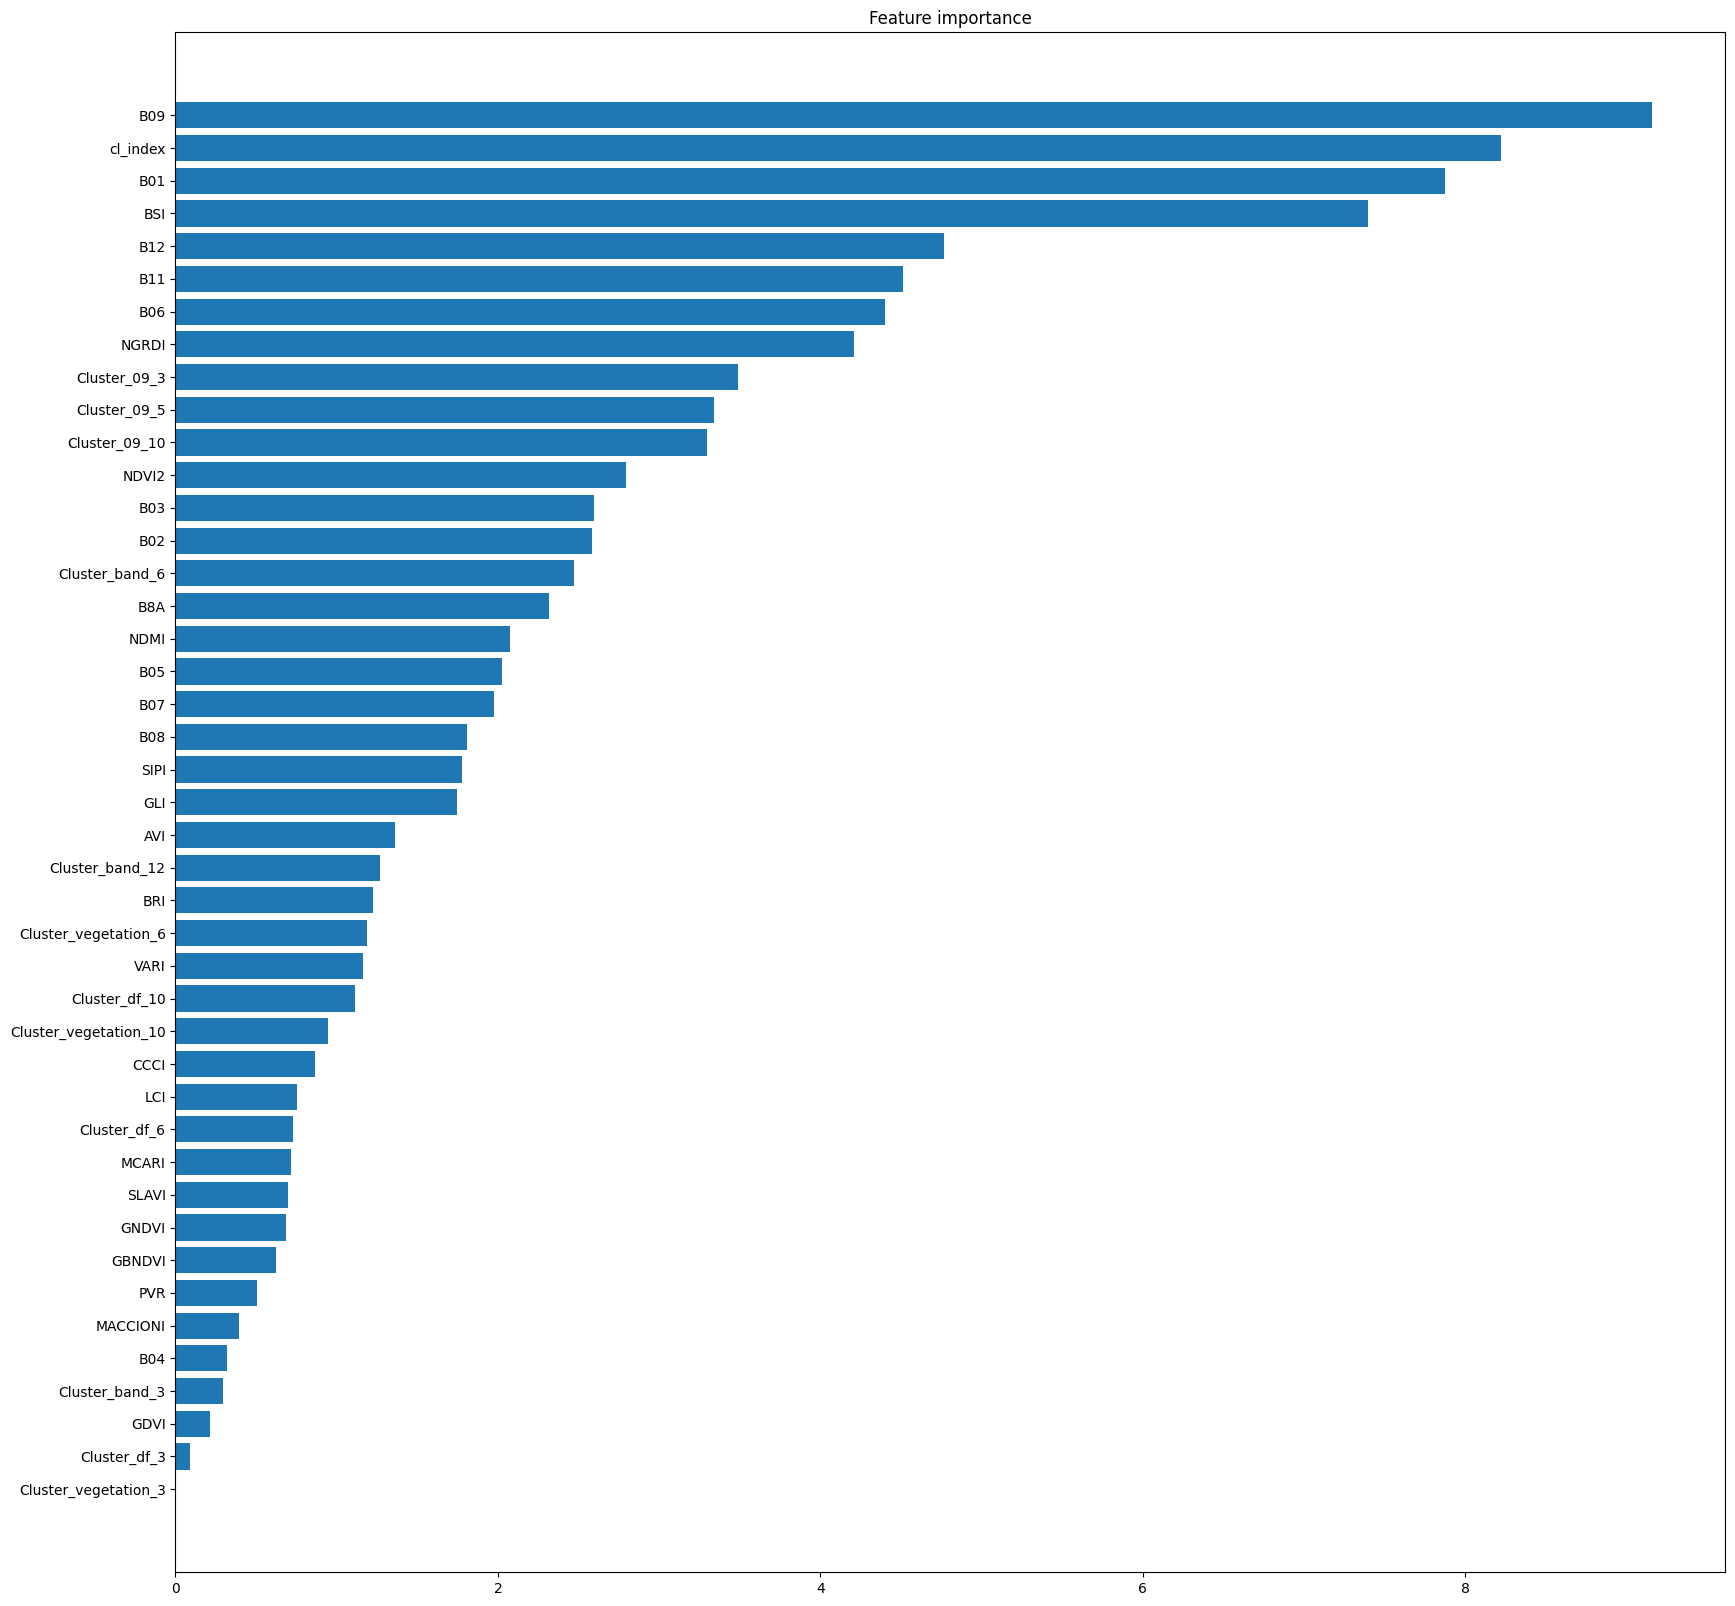

In [84]:
feat_imp = rf.feature_importances_
sorted_idx = np.argsort(feat_imp)
fig = plt.figure(figsize = (20,20))
plt.barh(range(len(sorted_idx)), feat_imp[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_trainsm.columns)[sorted_idx])
plt.title('Feature importance')

In [85]:
# trained classes

rf.classes_

array([ 1,  2,  3,  4,  5,  6,  8,  9, 13, 14, 15, 16, 36], dtype=int64)

In [263]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

In [272]:
y_trainsm = y_trainsm.astype(str)

In [276]:
y_trai = to_categorical(y_trainsm)

In [277]:
y_trai.shape

(234091, 37)

In [ ]:
#lets try deep learning

model = Sequential()
model.add(Dense(256, input_shape = (X_trainsm.shape[1], ), activation = 'relu'))
model.add(Dense(13, activation = 'softmax'))

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_trainsm,y_trainsm, validation_split = 0.2, shuffle = True, epochs = 15)

# MODEL EVALUATION

In [387]:
X_test = scaler.transform(X_test)

In [145]:
X_test_transformed = pca.transform(X_test)

In [914]:
from sklearn.metrics import classification_report, log_loss, confusion_matrix, roc_auc_score
y_pred_crop = rf.predict(X_test)

print(classification_report(y_test,y_pred_crop))

              precision    recall  f1-score   support

           1       0.64      0.85      0.73      2001
           2       0.54      0.40      0.46       973
           3       0.75      0.03      0.06       100
           4       0.80      0.78      0.79      1469
           5       1.00      0.05      0.10        20
           6       0.34      0.12      0.18       162
           8       0.67      0.04      0.08        46
           9       0.68      0.82      0.74       289
          13       0.80      0.41      0.55        58
          14       0.00      0.00      0.00        13
          15       0.57      0.10      0.17        39
          16       0.00      0.00      0.00        14
          36       0.77      0.26      0.39       116

    accuracy                           0.67      5300
   macro avg       0.58      0.30      0.33      5300
weighted avg       0.66      0.67      0.64      5300



D:\anacon\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anacon\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anacon\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [915]:
# X_test = scaler.fit_transform(X_test)

In [916]:
roc_auc_score(y_test,rf.predict_proba(X_test), multi_class = 'ovr')

0.9299809047436655

In [917]:
confusion_matrix(y_test,y_pred_crop)

array([[1709,  167,    1,   80,    0,   16,    1,   25,    2,    0,    0,
           0,    0],
       [ 480,  386,    0,   61,    0,   13,    0,   27,    4,    0,    0,
           0,    2],
       [  60,   16,    3,   21,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [ 213,   56,    0, 1142,    0,    6,    0,   45,    0,    0,    0,
           0,    7],
       [  15,    1,    0,    3,    1,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  90,   28,    0,   24,    0,   20,    0,    0,    0,    0,    0,
           0,    0],
       [  20,   21,    0,    2,    0,    1,    2,    0,    0,    0,    0,
           0,    0],
       [  15,   13,    0,   21,    0,    0,    0,  237,    0,    0,    3,
           0,    0],
       [  25,    8,    0,    0,    0,    1,    0,    0,   24,    0,    0,
           0,    0],
       [   8,    3,    0,    1,    0,    1,    0,    0,    0,    0,    0,
           0,    0],
       [  10,    8,    0,    8,    0,    0,    0, 

In [918]:
log_loss(y_test,rf.predict_proba(X_test))

0.8861462198803781

In [919]:
rf.predict(X_test)[2]

array([4], dtype=int64)

In [920]:
rf.predict_proba(X_test)[2]

array([3.88661958e-05, 7.03084049e-04, 8.03282987e-05, 9.21477811e-01,
       2.07710654e-03, 1.69379462e-04, 7.17513998e-06, 3.95511793e-05,
       4.22634609e-06, 5.00754815e-06, 4.02983253e-04, 2.45788682e-05,
       7.49699019e-02])

# Submit predictions with field_ids and class probabilites

- run predictions with trained model
- pass to multioutput predictions to csv file with field_id as index
- save output file as submission.csv

In [581]:
# extract crop_id-label dictionary

with open('ref_agrifieldnet_competition_v1/ref_agrifieldnet_competition_v1_labels_train/ref_agrifieldnet_competition_v1_labels_train_001c1/ref_agrifieldnet_competition_v1_labels_train_001c1.json') as ll:
    label_json = json.load(ll)

In [582]:
crop_dict = {asset.get('values')[0]:asset.get('summary') for asset in label_json['assets']['raster_labels']['file:values']}

In [583]:
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

In [584]:
def labeler(labeled):
    crop_label = np.array([crop_dict.get(f'{int(i)}') for i in labeled])
    return crop_label

In [136]:
tt = test_grouped.copy()

In [285]:
test_data_grouped = test_data_grouped.drop('field_id', axis=1 )

In [286]:
tc = test_data_grouped.columns

In [289]:
test_data_grouped = test_data_grouped[vector_names]

In [287]:
test_data_grouped = scaler.transform(test_data_grouped)


In [288]:
test_data_grouped  = pd.DataFrame(test_data_grouped, columns =  tc)

In [297]:
test_grouped

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,field_id,Cluster_band_6,Cluster_band_10,Cluster_band_15,Cluster_vegetation_6,Cluster_vegetation_10,Cluster_vegetation_15,Cluster_df_6,Cluster_df_10,Cluster_df_15
0,43.086957,39.057971,38.420290,38.405797,42.507246,59.536232,68.797101,64.405797,76.130435,12.507246,...,11,0,5,7,3,9,14,0,6,9
1,44.000000,40.692308,41.307692,46.769231,49.461538,61.076923,70.000000,65.461538,77.923077,13.000000,...,13,2,3,3,3,8,0,5,5,5
2,45.469388,41.918367,42.530612,44.367347,47.122449,62.469388,71.979592,66.265306,78.428571,12.000000,...,19,2,5,3,3,4,0,0,5,5
3,44.000000,40.250000,40.750000,40.000000,44.250000,64.250000,74.833333,69.583333,81.750000,12.000000,...,21,0,5,7,5,2,11,0,6,11
4,47.000000,44.300000,47.200000,52.900000,54.900000,67.300000,77.100000,71.200000,84.800000,13.000000,...,25,2,3,13,3,4,0,5,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,45.000000,36.333333,31.222222,24.722222,28.166667,54.888889,71.944444,67.833333,78.555556,14.444444,...,7319,1,4,1,2,5,4,2,2,13
1526,45.705882,37.735294,32.205882,26.205882,28.500000,52.823529,69.617647,66.970588,75.823529,13.500000,...,7325,1,4,1,2,2,4,2,2,13
1527,47.000000,40.588235,35.823529,30.823529,32.941176,51.705882,64.470588,59.352941,69.176471,11.235294,...,7329,1,0,6,3,4,3,2,3,14
1528,46.562500,40.000000,34.750000,29.125000,31.562500,52.250000,67.125000,63.500000,72.875000,11.000000,...,7330,1,4,1,5,9,11,2,2,3


In [367]:
scaling_data = test_data_grouped.drop('field_id', axis = 1)
test_data_scaled= scaler.transform(scaling_data)
test_data_grouped  = pd.DataFrame(test_data_scaled, columns = scaling_data.columns)

In [296]:
test_data_grouped

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,GBNDVI,LCI,MACCIONI,NGRDI,NDVI2,PVR,SLAVI,BSI,cl_index,cat
0,11,43.086957,39.057971,38.420290,38.405797,42.507246,59.536232,68.797101,64.405797,76.130435,...,-0.092135,0.212997,0.865045,-0.050501,-0.138174,0.000189,0.738820,0.326236,0.618479,3
1,13,44.000000,40.692308,41.307692,46.769231,49.461538,61.076923,70.000000,65.461538,77.923077,...,-0.112154,0.142563,0.884106,-0.089831,-0.049322,-0.062009,0.617114,0.351449,0.415241,3
2,19,45.469388,41.918367,42.530612,44.367347,47.122449,62.469388,71.979592,66.265306,78.428571,...,-0.120650,0.173031,0.900222,-0.051218,-0.073211,-0.021137,0.652270,0.319562,0.527501,3
3,21,44.000000,40.250000,40.750000,40.000000,44.250000,64.250000,74.833333,69.583333,81.750000,...,-0.075816,0.231179,0.877990,-0.041176,-0.201439,0.009288,0.806763,0.292868,0.691149,3
4,25,47.000000,44.300000,47.200000,52.900000,54.900000,67.300000,77.100000,71.200000,84.800000,...,-0.124770,0.131346,0.917355,-0.075416,0.006281,-0.056943,0.569600,0.370563,0.404372,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,7319,45.000000,36.333333,31.222222,24.722222,28.166667,54.888889,71.944444,67.833333,78.555556,...,0.002052,0.428571,0.927059,0.051450,-0.545570,0.116187,1.518657,0.153600,1.554241,3
1526,7325,45.705882,37.735294,32.205882,26.205882,28.500000,52.823529,69.617647,66.970588,75.823529,...,-0.021697,0.412879,0.947154,0.061047,-0.535919,0.102719,1.442052,0.138764,1.442724,3
1527,7329,47.000000,40.588235,35.823529,30.823529,32.941176,51.705882,64.470588,59.352941,69.176471,...,-0.125650,0.292890,0.937063,0.041916,-0.385038,0.075022,1.038066,0.125368,0.957143,3
1528,7330,46.562500,40.000000,34.750000,29.125000,31.562500,52.250000,67.125000,63.500000,72.875000,...,-0.081374,0.344804,0.935855,0.048068,-0.537065,0.088063,1.316062,0.085145,1.126733,3


In [137]:
test_data_grouped = pca.transform(test_grouped)

In [304]:
test_data_grouped['field_id'] = tt['field_id']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [921]:
predictions = rf.predict_proba(test_grouped.drop('field_id', axis =1))

crop_columns = [crop_dict.get(i) for i in rf.classes_]

test_df  = pd.DataFrame(columns= ['field_id'] + crop_columns)

test_df['field_id'] = test_grouped.field_id

test_df[crop_columns]= predictions 
test_df.to_csv('submission.csv', index=False)

In [922]:
test_df.sample(5)

,field_id,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
10471,219,0.516284,0.296614,0.011629,0.076621,0.025371,0.028518,0.000369,0.000106,0.001569,0.000436,0.041397,0.001029,0.000057
38251,2614,0.627813,0.253134,0.062524,0.026602,0.005046,0.009346,0.001504,0.000176,0.000724,0.009835,0.000270,0.003009,0.000017
14639,4321,0.000252,0.001306,0.000141,0.981164,0.000016,0.000150,0.000031,0.000310,0.000008,0.000002,0.000011,0.000023,0.016585
17661,2851,0.206182,0.502809,0.002971,0.141242,0.000844,0.035794,0.006041,0.003159,0.001514,0.073625,0.020784,0.004733,0.000303
17937,7267,0.121548,0.228599,0.000516,0.067383,0.000088,0.000538,0.000014,0.478892,0.000010,0.000009,0.026388,0.000011,0.076004
